# Notebook for visualizing the results of a stylegan3 training


In [45]:
import os, json
import matplotlib.pyplot as plt

results_dir = "training-runs/OITAVEN_TRAIN"
experiment_name = "00002-stylegan3-t-oitaven_train-gpus2-batch64-gamma0.125"

file_name = "stats.jsonl"

file_path = os.path.join(results_dir, experiment_name, file_name)
if not os.path.isfile(file_path):
    print(f"Error: The file {file_path} does not exist.")

# Labels for the classes
class_labels = range(10)

In [46]:
import numpy as np
import pandas as pd

class_colors = {
    0: "#f4341c",
    1: "#744c14",
    2: "#bbbbbb",
    3: "#5c6474",
    4: "#fae53a",
    5: "#ec8c3c",
    6: "#93d664",
    7: "#52b450",
    8: "#76933f",
    9: "#036400",
}

class_names = {
    0: "Auga",
    1: "Terra",
    2: "Pedras",
    3: "Asfalto",
    4: "Formigón",
    5: "Tellados",
    6: "Prados",
    7: "Árbores Nativas",
    8: "Piñeiros",
    9: "Eucaliptos",
}


def read_jsonl(file_path):
    """Reads a JSONL file and returns a list of parsed JSON objects."""
    with open(file_path, "r") as f:
        return [json.loads(line) for line in f]


def extract_metrics(jsonl_data, class_labels):
    """Extracts metrics from JSONL data into a dictionary of lists."""
    metric_keys = [
        "Loss/scores/fake",
        "Loss/signs/fake",
        "Loss/G/loss",
        "Loss/scores/real",
        "Loss/signs/real",
        "Loss/D/adversarial",
        "Loss/D/classification/real",
        "Loss/D/classification/real/val",
        "Loss/D/loss",
        "Loss/r1_penalty",
        "Loss/D/reg",
        "Progress/tick",
        "Progress/kimg",
        "Timing/total_sec",
        "Timing/sec_per_tick",
        "Timing/sec_per_kimg",
        "Timing/maintenance_sec",
        "Resources/cpu_mem_gb",
        "Resources/peak_gpu_mem_gb",
        "Resources/peak_gpu_mem_reserved_gb",
        "Progress/augment",
        "Timing/total_hours",
        "Timing/total_days",
        "Timing/Gboth",
        "Timing/Dmain",
        "Timing/Dreg",
        "timestamp",
    ]
    metric_keys.extend([f"Accuracy/{c}" for c in class_labels])
    metric_keys.extend([f"Accuracy/val/{c}" for c in class_labels])
    metrics = {key: [] for key in metric_keys}

    for entry in jsonl_data:
        for key in metric_keys:
            value = entry.get(key, None)
            if isinstance(value, dict) and "mean" in value:
                metrics[key].append(value["mean"])
            else:
                metrics[key].append(value)
    return metrics


def _build_classification_keys(class_labels, val=True):
    """Builds classification keys for the given class labels."""
    prefix = "Accuracy/val" if val else "Accuracy"
    return [f"{prefix}/{c}" for c in class_labels]


def extract_classification_metrics(jsonl_data, class_labels):
    """Extracts classification metrics (mean and num) from the JSONL data into a dictionary."""
    classification_keys = _build_classification_keys(class_labels, val=False) + _build_classification_keys(
        class_labels, val=True
    )
    metrics = {key: {"mean": [], "num": []} for key in classification_keys}

    for entry in jsonl_data:
        for key in classification_keys:
            if key in entry:
                # Handle nested keys with "mean" and "num" values
                if isinstance(entry[key], dict):
                    metrics[key]["mean"].append(entry[key].get("mean", None))
                    metrics[key]["num"].append(entry[key].get("num", None))
                else:
                    metrics[key]["mean"].append(None)
                    metrics[key]["num"].append(None)
            else:
                metrics[key]["mean"].append(None)
                metrics[key]["num"].append(None)

    return metrics


def format_time(seconds):
    """
    Formats time in seconds into a human-readable format like '16h 20min 16s'.
    """
    hours, remainder = divmod(int(seconds), 3600)
    minutes, seconds = divmod(remainder, 60)
    formatted_time = []
    if hours > 0:
        formatted_time.append(f"{hours}h")
    if minutes > 0:
        formatted_time.append(f"{minutes}min")
    if seconds > 0 or not formatted_time:
        formatted_time.append(f"{seconds}s")
    return " ".join(formatted_time)


def summarize_training_stats(metrics, exclude_first_tick=True, display_hour_format=True):
    """
    Summarizes and displays training statistics, including total time, kimg, ticks,
    and mean/std of time per tick and per kimg.

    Args:
        data (dict): Dictionary containing training metrics.
        exclude_first_tick (bool): Whether to exclude the first tick from calculations.
        display_hour_format (bool): Whether to display total time in hh:mm:ss format.
    """
    first_index = 1 if exclude_first_tick else 0

    # Extract metrics
    total_kimg = metrics["Progress/kimg"][-1]
    total_ticks = metrics["Progress/tick"][-1]
    total_time_sec = metrics["Timing/total_sec"][-1]
    mean_sec_per_tick = np.mean(metrics["Timing/sec_per_tick"][first_index:])
    std_sec_per_tick = np.std(metrics["Timing/sec_per_tick"][first_index:])
    mean_sec_per_kimg = np.mean(metrics["Timing/sec_per_kimg"][first_index:])
    std_sec_per_kimg = np.std(metrics["Timing/sec_per_kimg"][first_index:])

    # Format total time
    if display_hour_format:
        total_time_formatted = format_time(total_time_sec)
        print(f"🕒 Total time: {total_time_formatted}")
    else:
        print(f"🕒 Total time: {total_time_sec:.2f} seconds")

    # Format time per tick
    mean_tick_time = format_time(mean_sec_per_tick)
    std_tick_time = format_time(std_sec_per_tick)

    # Format time per kimg
    mean_kimg_time = format_time(mean_sec_per_kimg)
    std_kimg_time = format_time(std_sec_per_kimg)

    # Display results
    print(f"📊 Total kimg: {round(total_kimg, 3)}")
    print(f"📈 Total ticks: {int(total_ticks)}")
    print(f"⏱️ Mean time per tick: {mean_tick_time} (std: {std_tick_time})")
    print(f"⏳ Mean time per kimg: {mean_kimg_time} (std: {std_kimg_time})")


def identify_best_tick(metrics, key="Loss/D/classification/real/val"):
    """Identifies the best tick based on the specified key in the metrics."""

    if key not in metrics:
        raise ValueError(f"Key '{key}' not found in metrics.")

    values = np.array(metrics[key])
    best_tick = np.argmin(values)
    return best_tick


def extract_best_tick(
    metrics, classification_metrics, class_labels, key="Loss/D/classification/real/val", class_names=None
):
    """
    Extracts the best tick from the metrics based on the specified key.
    Generates tables with classification metrics (per-class accuracy, AA, OA) and losses (G and D).
    """
    if key not in metrics:
        raise ValueError(f"Key '{key}' not found in metrics.")

    # Find the best tick based on the specified key
    best_tick = identify_best_tick(metrics, key)

    # Table 1: Accuracy per class in validation and training
    keys = (
        [f"Class {c}" for c in class_labels]
        if class_names is None
        else [f"{class_names[c]} ({c+1})" for c in class_labels]
    )
    acc_per_class_val = {key: [metrics[f"Accuracy/val/{c}"][best_tick]] for key, c in zip(keys, class_labels)}
    acc_per_class_train = {f"Class {c}": [metrics[f"Accuracy/{c}"][best_tick]] for c in class_labels}
    df_acc_per_class = pd.DataFrame(acc_per_class_val, index=["Accuracy"])

    # Table 2: AA and OA in validation and training
    avg_acc_train, std_acc_train, avg_acc_val, std_acc_val = compute_avg_accuracy(
        metrics, clean_nan=False, class_labels=class_labels
    )
    overall_acc_train, overall_acc_val = compute_overall_accuracy(classification_metrics)
    aa_val = avg_acc_val[best_tick]
    oa_val = overall_acc_val[best_tick]
    aa_train = avg_acc_train[best_tick]
    oa_train = overall_acc_train[best_tick]
    df_aa_oa = pd.DataFrame({"Validation": [aa_val, oa_val], "Training": [aa_train, oa_train]}, index=["AA", "OA"])

    # Tabla 3: Losses (D and G)
    loss_d = metrics["Loss/D/adversarial"][best_tick]
    loss_g = metrics["Loss/G/loss"][best_tick]
    df_losses = pd.DataFrame(
        {
            "Loss/D/adversarial": [loss_d],
            "Loss/G/loss": [loss_g],
            "Loss/D/classification/real/val": [metrics[key][best_tick]],
            "Loss/D/classification/real": [metrics["Loss/D/classification/real"][best_tick]],
        },
        index=["Best Tick"],
    )

    return df_acc_per_class, df_aa_oa, df_losses


def extract_confusion_matrix(jsonl_data, class_labels, tick=None, val=True):
    """Extracts confusion matrix data from JSONL data."""
    num_classes = len(class_labels)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    entry = jsonl_data[-1] if tick is None else jsonl_data[tick]

    for real_class in class_labels:
        for pred_class in class_labels:
            key = f"Classification" + ("/val/" if val else "/") + f"{real_class}/{pred_class}"
            value = entry[key]
            if isinstance(value, dict) and "mean" in value and "num" in value:
                confusion_matrix[real_class, pred_class] = int(value["mean"] * value["num"])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix, class_labels):
    """Plots a confusion matrix with a heatmap and text annotations."""
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(
                j,
                i,
                int(confusion_matrix[i, j]),
                horizontalalignment="center",
                color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black",
            )

    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.tight_layout()
    plt.show()


def plot_metric(
    metrics, metrics_to_plot, x_axis="Progress/kimg", colors=None, marker="o", title=None, ylim=None, labels=None
):
    """Plots specific metrics against the x-axis."""
    if not labels:
        labels = metrics_to_plot
    elif len(labels) != len(metrics_to_plot):
        raise ValueError("Length of labels must match length of metrics_to_plot.")

    plt.figure(figsize=(10, 5))
    for i, (metric, label) in enumerate(zip(metrics_to_plot, labels)):
        if metric in metrics:
            color = colors[i] if colors and i < len(colors) else None
            plt.plot(metrics[x_axis], metrics[metric], label=label, color=color, marker=marker)
    plt.xlabel(x_axis)
    plt.ylabel("Metric Value")
    if ylim:
        plt.ylim(ylim)
    plt.title(title or f"{', '.join(metrics_to_plot)} vs {x_axis}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


def print_accuracies_per_class(metrics, class_labels, last_ticks=10, val=True, class_names=None):
    """
    Prints the accuracies for each class from the classification loss metrics.
    """
    classification_keys = _build_classification_keys(class_labels, val=val)
    accuracies = [metrics[metric][-last_ticks:] for metric in classification_keys]
    accuracies = np.array(accuracies)
    print(f"Last {last_ticks} accuracies per class:")
    for class_label, acc in zip(class_labels, accuracies):
        if not class_names:
            print(f"Class {class_label}: {[f'{a:.3f}' for a in acc]}")
        else:
            print(f"{class_names[class_label]} ({class_label+1}): {[f'{a:.3f}' for a in acc]}")
    avg = np.mean(accuracies, axis=0)
    formatted = [f"{v:.3f}" for v in avg]
    print(f"Average accuracies over the last {last_ticks} ticks: {formatted}")


def compute_avg_accuracy(metrics, clean_nan, class_labels):
    """
    Computes the average accuracy from the classification loss metrics.
    """
    classification_keys = _build_classification_keys(class_labels, val=False) + _build_classification_keys(
        class_labels, val=True
    )
    accuracies_train = [metrics[metric] for metric in classification_keys if not metric.startswith("Accuracy/val/")]
    accuracies_val = [metrics[metric] for metric in classification_keys if metric.startswith("Accuracy/val/")]
    if clean_nan:
        accuracies_train = [np.nan_to_num(acc, nan=0) for acc in accuracies_train]
        accuracies_val = [np.nan_to_num(acc, nan=0) for acc in accuracies_val]

    accuracies_train = np.array(accuracies_train)
    accuracies_val = np.array(accuracies_val)
    return (
        np.mean(accuracies_train, axis=0),
        np.std(accuracies_train, axis=0),
        np.mean(accuracies_val, axis=0),
        np.std(accuracies_val, axis=0),
    )


def compute_overall_accuracy(metrics):
    """
    Computes the overall accuracy from the classification metrics.
    """
    total_correct_train = None
    total_samples_train = None

    total_correct_val = None
    total_samples_val = None

    for key, values in metrics.items():
        means = np.array(values["mean"])
        means = np.nan_to_num(means, nan=0.0)
        nums = np.array(values["num"])

        if key.startswith("Accuracy/val/"):
            if total_correct_val is None:
                total_correct_val = np.zeros_like(means)
                total_samples_val = np.zeros_like(nums)

            total_correct_val += means * nums
            total_samples_val += nums
        elif key.startswith("Accuracy/"):
            if total_correct_train is None:
                total_correct_train = np.zeros_like(means)
                total_samples_train = np.zeros_like(nums)

            total_correct_train += means * nums
            total_samples_train += nums

    return total_correct_train / total_samples_train, total_correct_val / total_samples_val


def plot_accuracies(data, class_labels=range(10), plot_std_in_avg_accuracy=True, plot_type="both", set="both"):
    """
    Plots the overall accuracy, average accuracy, or both over time.

    Args:
        data (dict): Dictionary containing the metrics data.
                     Should include keys like 'overall_accuracy_train' and/or 'overall_accuracy_val'
                     depending on the value of `set`.
        class_labels (list): List of class labels (default is range(10)).
        plot_std_in_avg_accuracy (bool): Whether to plot the standard deviation in the average accuracy plot.
        plot_type (str): Type of plot to generate. Options are:
                         - "overall": Plot only overall accuracy.
                         - "average": Plot only average accuracy.
                         - "both": Plot both overall and average accuracy in the same plot.
        set (str): Dataset to plot overall accuracy for: "train", "val", or "both". Default is "both".
    """
    if plot_type not in ["overall", "average", "both"]:
        raise ValueError("Invalid plot_type. Choose from 'overall', 'average', or 'both'.")
    if set not in ["train", "val", "both"]:
        raise ValueError("Invalid set. Choose from 'train', 'val', or 'both'.")

    # Plot Overall Accuracy
    if plot_type in ["overall", "both"]:
        plt.figure(figsize=(10, 5))
        if set in ["train", "both"]:
            plt.plot(
                data["Progress/kimg"],
                data["overall_accuracy_train"],
                label="Overall Accuracy Train",
                marker="o",
                color="skyblue",
            )
        if set in ["val", "both"]:
            plt.plot(
                data["Progress/kimg"],
                data["overall_accuracy_val"],
                label="Overall Accuracy Val",
                marker="s",
                color="orange",
            )
        plt.xlabel("Progress/kimg")
        plt.ylabel("Overall Accuracy")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if plot_type == "overall":
            plt.title(f"Overall Accuracy ({set.title()}) vs Progress/kimg")
            plt.show()

    # Compute Average Accuracy and Standard Deviation
    if plot_type in ["average", "both"]:
        avg_accuracy_train, std_accuracy_train, avg_accuracy_val, std_accuracy_val = compute_avg_accuracy(
            data, clean_nan=True, class_labels=class_labels
        )

        if plot_type == "average":
            plt.figure(figsize=(10, 5))
        if set in ["train", "both"]:
            plt.plot(
                data["Progress/kimg"], avg_accuracy_train, label="Average Train Accuracy", marker="o", color="green"
            )
        if set in ["val", "both"]:
            plt.plot(data["Progress/kimg"], avg_accuracy_val, label="Average Val Accuracy", marker="s", color="red")
        if plot_std_in_avg_accuracy:
            if set in ["train", "both"]:
                plt.fill_between(
                    data["Progress/kimg"],
                    avg_accuracy_train - std_accuracy_train,
                    avg_accuracy_train + std_accuracy_train,
                    alpha=0.2,
                    label="Standard Deviation Train",
                    color="green",
                )
            if set in ["val", "both"]:
                plt.fill_between(
                    data["Progress/kimg"],
                    avg_accuracy_val - std_accuracy_val,
                    avg_accuracy_val + std_accuracy_val,
                    alpha=0.2,
                    label="Standard Deviation Val",
                    color="red",
                )

        plt.xlabel("Progress/kimg")
        plt.ylabel("Average Accuracy")
        if plot_type == "average":
            plt.title("Average Accuracy vs Progress/kimg")
        else:
            plt.title("Overall and Average Accuracy vs Progress/kimg")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.close("all")


import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(confusion_matrix, class_labels, title="Confusion Matrix"):
    """
    Plots a confusion matrix with a heatmap and text annotations.

    Args:
        confusion_matrix (np.ndarray): 2D NumPy array representing the confusion matrix.
        class_labels (list): List of class labels corresponding to the rows and columns of the matrix.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    # Add labels to the axes
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    # Add text annotations in each cell
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(
                j,
                i,
                int(confusion_matrix[i, j]),
                horizontalalignment="center",
                color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black",
            )

    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.tight_layout()
    plt.show()

In [47]:
jsonl_data = read_jsonl(file_path)
metrics = extract_metrics(jsonl_data, class_labels=class_labels)
summarize_training_stats(metrics, exclude_first_tick=True)

🕒 Total time: 17h 39min 42s
📊 Total kimg: 1134.016
📈 Total ticks: 113
⏱️ Mean time per tick: 9min 12s (std: 33s)
⏳ Mean time per kimg: 55s (std: 3s)


In [48]:
classification_metrics = extract_classification_metrics(jsonl_data, class_labels=class_labels)
best_tick = identify_best_tick(metrics, key="Loss/D/classification/real/val")
df_acc_per_class, df_aa_oa, df_losses = extract_best_tick(
    metrics,
    classification_metrics,
    key="Loss/D/classification/real/val",
    class_labels=class_labels,
    class_names=class_names,
)

print("Table 0: General information about the training run (best tick, progress, and loss)")

general_info = pd.DataFrame(
    {
        "Tick": [best_tick],
        "Progress/kimg": [metrics["Progress/kimg"][best_tick]],
        "Loss/D/classification/real/val": [metrics["Loss/D/classification/real/val"][best_tick]],
    },
    index=["Best Tick"],
)
display(general_info)

print("Table 1: Accuracy per class in validation")
display(df_acc_per_class)

print("Table 2: Average Accuracy (AA) and Overall Accuracy (OA) in validation and training")
display(df_aa_oa)

print("Table 3: Losses (D and G)")
display(df_losses)

Table 0: General information about the training run (best tick, progress, and loss)


,Tick,Progress/kimg,Loss/D/classification/real/val
Best Tick,23,231.167999,0.3015


Table 1: Accuracy per class in validation


,Auga (1),Terra (2),Pedras (3),Asfalto (4),Formigón (5),Tellados (6),Prados (7),Árbores Nativas (8),Piñeiros (9),Eucaliptos (10)
Accuracy,0.934783,0.72,0.666667,0.857143,0.833333,0.533333,0.930435,0.918206,0.979167,0.861878


Table 2: Average Accuracy (AA) and Overall Accuracy (OA) in validation and training


,Validation,Training
AA,0.823494,0.920006
OA,0.899816,0.950139


Table 3: Losses (D and G)


,Loss/D/adversarial,Loss/G/loss,Loss/D/classification/real/val,Loss/D/classification/real
Best Tick,0.807238,2.365878,0.3015,0.149862


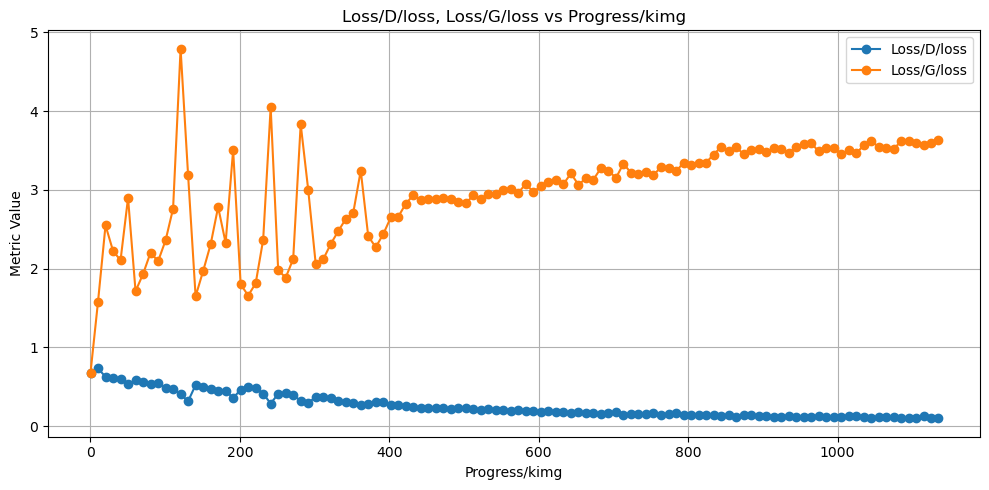

In [49]:
plot_metric(metrics, metrics_to_plot=["Loss/D/loss", "Loss/G/loss"], x_axis="Progress/kimg")

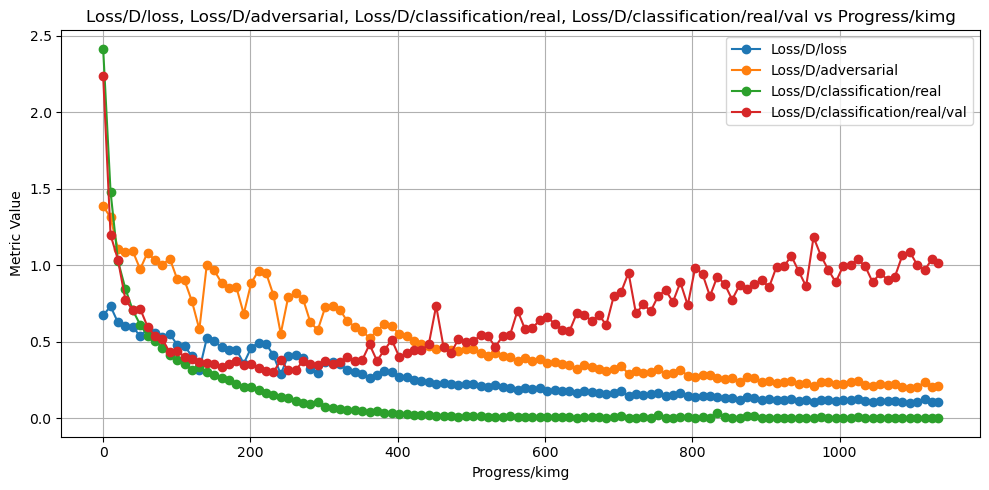

In [50]:
plot_metric(
    metrics,
    metrics_to_plot=[
        "Loss/D/loss",
        "Loss/D/adversarial",
        "Loss/D/classification/real",
        "Loss/D/classification/real/val",
    ],
    x_axis="Progress/kimg",
)

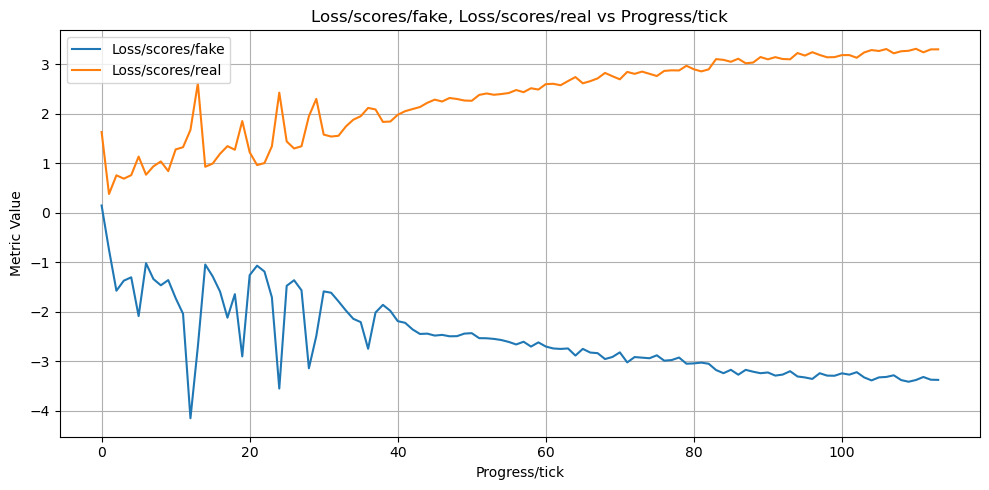

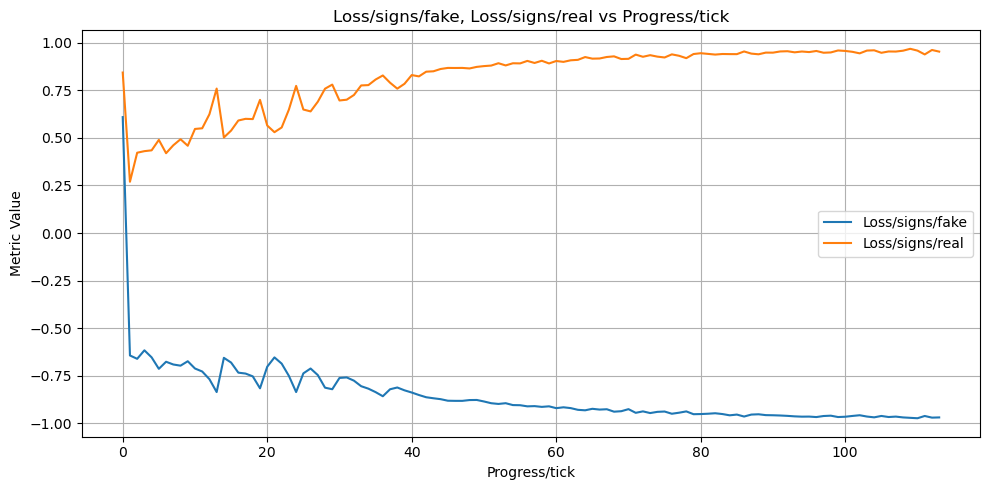

In [51]:
plot_metric(metrics, metrics_to_plot=["Loss/scores/fake", "Loss/scores/real"], x_axis="Progress/tick", marker=None)
plot_metric(metrics, metrics_to_plot=["Loss/signs/fake", "Loss/signs/real"], x_axis="Progress/tick", marker=None)

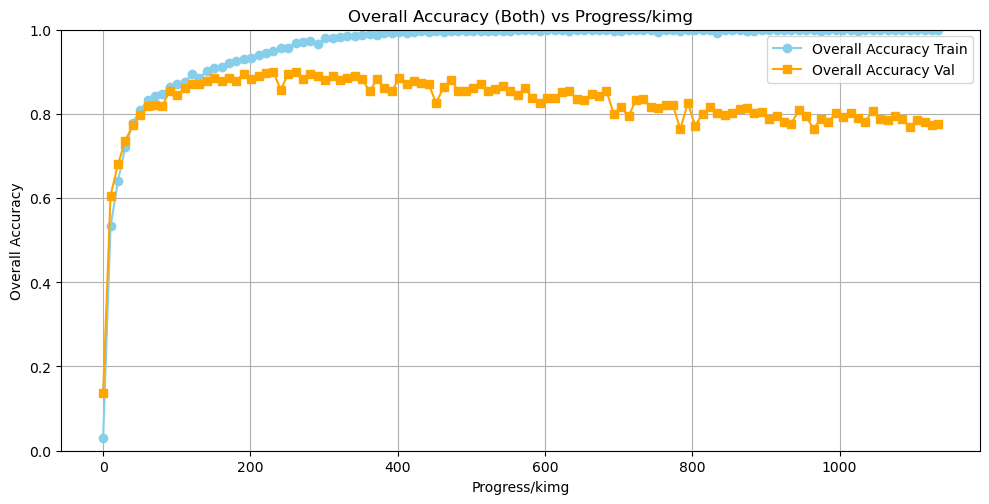

In [52]:
classification_metrics = extract_classification_metrics(jsonl_data, class_labels=class_labels)
metrics["overall_accuracy_train"], metrics["overall_accuracy_val"] = compute_overall_accuracy(classification_metrics)
plot_accuracies(metrics, class_labels=class_labels, plot_std_in_avg_accuracy=False, plot_type="overall", set="both")

Last 10 accuracies per class:
Class 0: ['0.783', '0.870', '0.761', '0.804', '0.696', '0.652', '0.826', '0.609', '0.652', '0.717']
Class 1: ['0.640', '0.640', '0.480', '0.560', '0.640', '0.600', '0.480', '0.640', '0.600', '0.560']
Class 2: ['0.556', '0.333', '0.278', '0.556', '0.500', '0.444', '0.556', '0.389', '0.444', '0.389']
Class 3: ['0.714', '0.857', '0.857', '0.714', '0.857', '0.857', '0.857', '0.857', '0.857', '0.857']
Class 4: ['0.667', '0.750', '0.875', '0.750', '0.708', '0.458', '0.792', '0.625', '0.750', '0.792']
Class 5: ['0.467', '0.467', '0.533', '0.400', '0.400', '0.467', '0.467', '0.333', '0.400', '0.400']
Class 6: ['0.841', '0.875', '0.817', '0.867', '0.855', '0.925', '0.823', '0.887', '0.878', '0.878']
Class 7: ['0.871', '0.818', '0.868', '0.805', '0.858', '0.765', '0.847', '0.794', '0.799', '0.786']
Class 8: ['0.917', '0.854', '0.896', '0.958', '0.938', '0.833', '0.896', '0.896', '0.812', '0.917']
Class 9: ['0.685', '0.619', '0.630', '0.691', '0.580', '0.608', '0.635

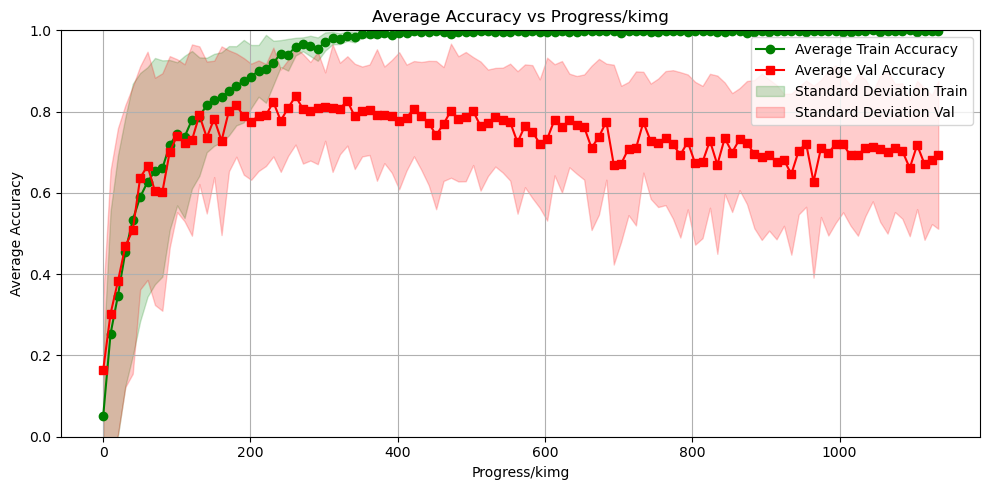

In [53]:
print_accuracies_per_class(metrics, class_labels, last_ticks=10, val=True)
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="average",
    set="both",
)

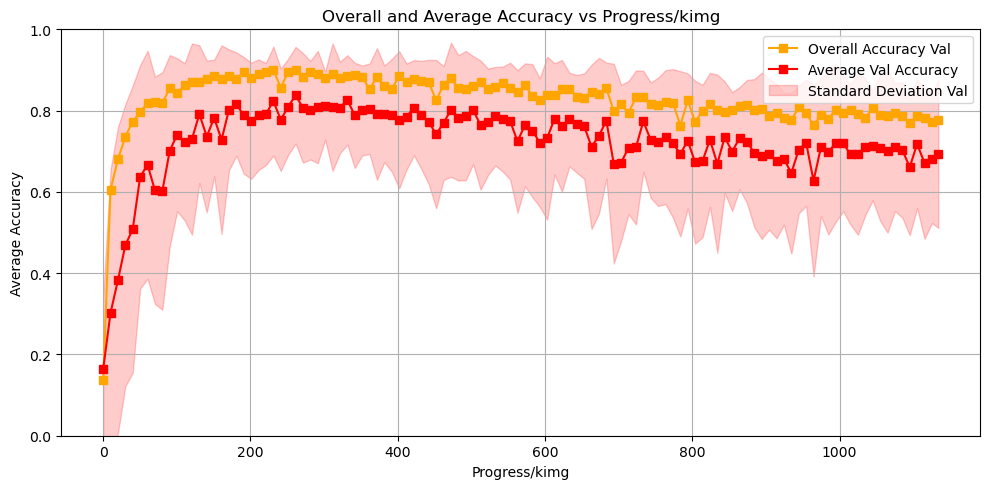

In [54]:
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="both",
    set="val",
)

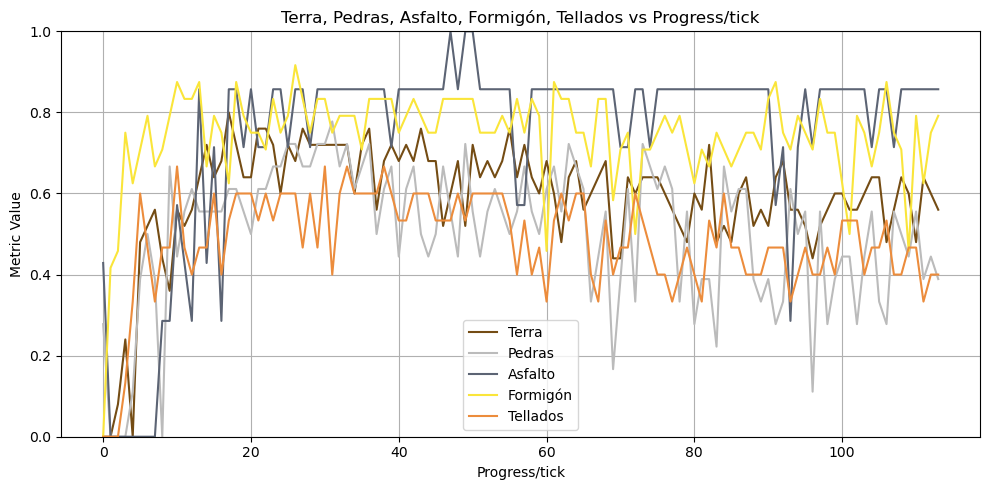

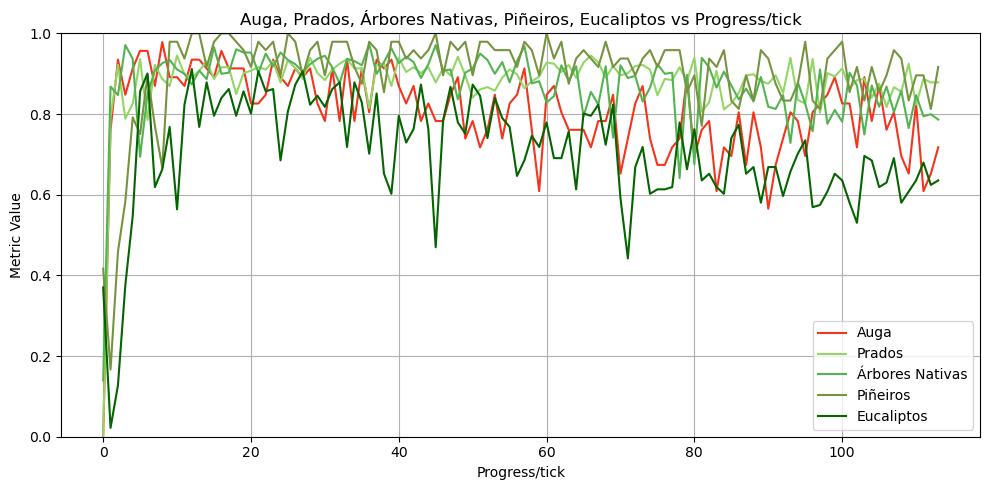

In [55]:
if "oitaven" in experiment_name:
    minority_class_labels = [1, 2, 3, 4, 5]
    colors = [class_colors[c] for c in minority_class_labels]
    plot_metric(
        metrics,
        metrics_to_plot=[f"Accuracy/val/{c}" for c in minority_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="Terra, Pedras, Asfalto, Formigón, Tellados vs Progress/tick",
        labels=[class_names[c] for c in minority_class_labels],
    )
    mayority_class_labels = [0, 6, 7, 8, 9]
    colors = [class_colors[c] for c in mayority_class_labels]
    plot_metric(
        metrics,
        metrics_to_plot=[f"Accuracy/val/{c}" for c in mayority_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="Auga, Prados, Árbores Nativas, Piñeiros, Eucaliptos vs Progress/tick",
        labels=[class_names[c] for c in mayority_class_labels],
    )
else:
    first_class_labels = [0, 1, 2, 3, 4]
    colors = [class_colors[c] for c in first_class_labels]
    plot_metric(
        metrics,
        metrics_to_plot=[f"Accuracy/val/{c}" for c in first_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="0, 1, 2, 3, 4 vs Progress/tick",
    )
    last_class_labels = [5, 6, 7, 8, 9]
    colors = [class_colors[c] for c in last_class_labels]
    plot_metric(
        metrics,
        metrics_to_plot=[f"Accuracy/val/{c}" for c in last_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="5, 6, 7, 8, 9 vs Progress/tick",
    )

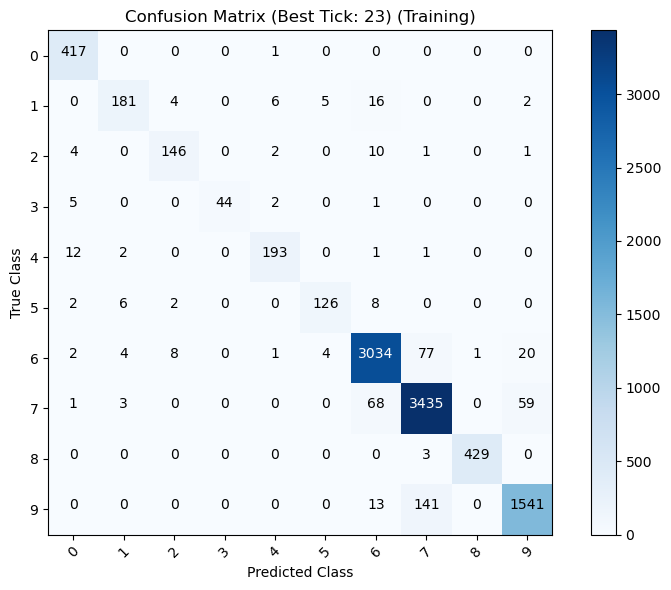

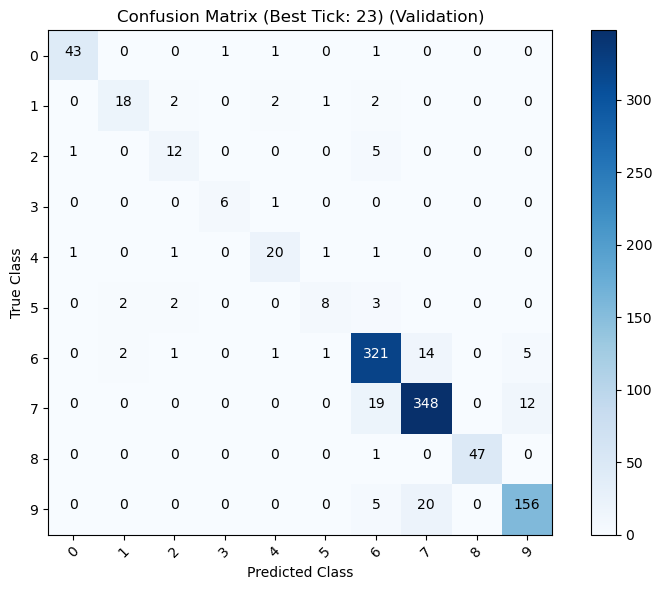

In [56]:
best_tick = identify_best_tick(metrics, key="Loss/D/classification/real/val")
title = f"Confusion Matrix (Best Tick: {best_tick})" if best_tick is not None else "Confusion Matrix (Last Entry)"
confusion_matrix = extract_confusion_matrix(jsonl_data, class_labels=class_labels, tick=best_tick, val=False)
plot_confusion_matrix(confusion_matrix, class_labels=class_labels, title=title + " (Training)")
confusion_matrix = extract_confusion_matrix(jsonl_data, class_labels=class_labels, tick=best_tick, val=True)
plot_confusion_matrix(confusion_matrix, class_labels=class_labels, title=title + " (Validation)")